### This notebook chronicles the development of a myopic time-series model for running your vehicle on autopilot in a game such as GTA 5 or Forza.

# THEORY:

### Recurrent LSTM networks are fairly good at predicting on time series data. However, I've made a slight mathematical adjustment to the recurrent training data- instead of training the model on a series of discrete data points indicating net displacement, I've augmented the data to represent a series of Gaussian distributions centred around the ground-truth value from the original dataset.

### This has a few properties: 

### (1) The predictions Y_n are a function of a randomly sampled value Y_n-1; in the limit as the amount of such recurrent samples approaches infinity, the distribution of training data becomes a Gaussian distribution function. Through integral calculus, it can be shown that the expectation value of each distribution is equal to the value before the one being predicted. This allows us to model our time series data as a martingale, which is fitting since noisy data undergoes geometric brownian motion, and enables us to regularise the data to many possible outcomes as a result, i.e. order from chaos. 

### (2) Since the data is a martingale AND a Gaussian process, using Baye's theorem for several joint probabilities, it can be shown that the logarithm of the probability of predicting a certain value does in fact vary proportionally to the expectation value of the mean-squared-loss function from linear regression models. 

### TL;DR Applying a regularization technique from variational autoencoders to a LSTM model allows us to take advantage of the recurrent  nature of the model to basically train it on a martingale, and then because of how the math works out (pen and paper wise), can be treated as a regular problem just by using a mean-squared-error loss function. Additionally, because Gaussians are continuous and infinitely differentiable (although they don't have the nicest derivatives), I'm led to believe that backpropagation will train the network using information from these Gaussians and hence generalize the model to adapt to them more in the future. 

# APPLICATION: 

### What we have is a time series model to predict the behaviour of a car in 2 dimensions. Assuming that a video game obeys most of the laws of classical mechanics, it should suffice to calculate things like velocity and acceleration by computing first and second order derivatives of the position in 2D.

### The ML model predicts the components of acceleration in the plane of the road when activated. While 'inactive', the model is training in the background on keylogger data. This is done simultaneously via implementing both the model and a keylogger via python's multithreading module. The force is (assumed) constant, and when the user leaves his chair to accept a pizza at the front door, the keylogger will detect that there has been no user input for long enough that autopilot kicks in!

### The network determines based on Gaussians centred around recent driving data what keys to press, i.e. hit the brakes or gas, right or left turn holds. Granted, in this naive form, the car is able to predict human driving patterns-but it is completely blind. The assumption is that you have enough time to answer the door, return and hopefully you haven't crashed! 

In [1]:
#Data pipeline has 3 parts:

#2 Model training threads

#Keylogging thread 

#Model deployment thread 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyautogui

In [3]:
#Data Preprocessing
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
#Time Series Machine Learning Based
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout  
from keras.models import Sequential 
import tensorflow as tf
#Discrete

2022-09-24 02:40:05.341419: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dolan/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-09-24 02:40:05.341469: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [64]:
from multiprocessing import Process
import time 
import os
import random
from pynput.keyboard import Key, Listener, KeyCode
import logging


In [5]:
logdir = os.getcwd() + '/'
logdir

'/home/dolan/Desktop/DataScience/selfdriving/'

In [6]:
#Multithreading practice example

counter = 0

def fizz():
    global counter 
    while counter < 10:
        print('fizz', counter)
        counter += 1
def buzz():
    global counter 
    while counter < 10:
        print('buzz', counter)
        counter += 1
p1 = Process(target = fizz)
p1.start()
p2 = Process(target = buzz)
p2.start()


fizz buzz0
fizz  10
buzz
 fizz 1
buzz2 
2
buzz 3
fizz buzz3 
fizz 4
buzz 45

buzz 6
fizzbuzz 5
 7
fizzbuzz  86
fizz
 7
fizz buzz8
fizz 9
 9


In [118]:
class Vehicle:
    
    def __init__(self, memory_window_size, model):
        self.latest_vx = 0.0
        self.latest_vy = 0.0 #2D velocity components
        '''In order to have up-to-data training data, the two arrays must be QUEUES.
        The oldest information needs to be forgotten first, so pop from the front of each every time
        a new value is added to the velocity data for the graph.
        
        #Assumption is that by cumulatively adding increments of the acceleration with each keypress,
        the sum in the onPress function effectively numerically integrates the acceleration wrt time,
        i,e. += 1.0 * alpha, our incremental change in time (although we should adjust this by finding differences
        in Unix time!)
        
        
        '''
        self.model = model
        self.key = None
        self.history = None
        self.vx = [] #Update this parameter with new values each time
        self.vy = []
        self.x_predicted, self.y_predicted = [], []
        
#         self.X_horizontal = None
#         self.y_horizontal = None
        
#         self.X_vertical = None
#         self.y_vertical = None
        
        self.memory_window_size = memory_window_size
        
        self.X_horizontal, self.y_horizontal = [0] * memory_window_size , [0] * memory_window_size
        self.X_vertical, self.y_vertical  = [0] * memory_window_size , [0] * memory_window_size

        
        
        self.time_elapsed = 0.0
        self.array = []
        
        self.numerical_integration_enabled = True
        
        
    def onPress(self,key):
        numerical_integration_enabled= self.numerical_integration_enabled
        w = KeyCode.from_char("w")
        s = KeyCode.from_char("s")
        d = KeyCode.from_char("d")
        a = KeyCode.from_char("a")
        p = KeyCode.from_char("p")
        logging.info(str(key))
        self.key = key #Store this value in the data structure to get 
#         self.array.append(key)
        if self.numerical_integration_enabled is True:
            alpha = time.time()
        else:
            alpha = 0.1 #If numerical integration is not enabled, keep timestep constant 
        if key == Key.esc:
            print(self.latest_vy)
            return False
        elif key == p:
            print("autopilot is activated")
#             self.predict_keys()
        elif key == w:
            #Perform numerical integration over each timestep 
            if self.numerical_integration_enabled is True:
                alpha -= time.time()                         #Calculate the timestep after the keypress is detected
            self.latest_vy += 1.0 * alpha#Accelerate
            self.vy.append(self.latest_vy)
            
            self.vx.append(self.latest_vx)
        elif key == s:
            if self.numerical_integration_enabled is True:
                alpha -= time.time() 

            self.latest_vy -= 1.0 * alpha#Decelerate
            self.vy.append(self.latest_vy)
            
            self.vx.append(self.latest_vx)
            
        elif key == d:
            if self.numerical_integration_enabled is True:
                alpha -= time.time() 

            self.latest_vx += 1.0 * alpha#Turn right
            self.vx.append(self.latest_vx)
            
            self.vy.append(self.latest_vy)
            
        elif key == a:
            if self.numerical_integration_enabled is True:
                alpha -= time.time()             
            self.latest_vx -= 1.0 * alpha#Turn left!
            self.vx.append(self.latest_vx)
            
            self.vy.append(self.latest_vy) #If the horizontal keys are pressed, 
                                           #assume that from Newton's 1st law (given ~0 friction force for now) 
                                           #that motion of the vehicle in the other coordinate remains constant.
                                           #We'll dampen this with friction data later!
            
        else:
            pass
#         print(alpha)
        print(self.latest_vx, self.latest_vy)

        #if key == Key.esc:
        # return false
    def listen(self):
        with Listener(on_press = self.onPress) as listener:
            listener.join() 
 
    
    def gaussian_noise(self, value, num_noise_pts=100):
        sigma = 0.2
        return np.random.normal(value, sigma,(num_noise_pts, 1)) #standard deviation can be obtained more accu 
    
    def predict_keys(self, vertical):
        '''Generate a series of normally distributed random variables at each successive timestep alpha'''
        mean = None
        sigma = 0.25
        if vertical is True:
            x_test, y_test = None,  self.latest_vy #Randomly initialize the first mu
            
        else:
            x_test, y_test = None, self.latest_vx #y_test is label data, vy is vertical...
        predictions = []
        y_test_examples = []
        #Initially, Gauss is null And 
        counter = 0
            
        
        while counter < 50:
            x_test = np.random.normal(y_test, sigma, (100,1))
            y_test = x_test[random.randint(0, len(x_test)-1)] #Select a random number from the previous gauss_ dis
            y_test_examples.append(y_test)
            test_prediction = model.predict(np.expand_dims(x_test, axis=0))
            print(test_prediction[0][0])
            if vertical is True:
                self.y_predicted.append(test_prediction[0][0])
                if test_prediction > y_test:
                    print('w')
                    pyautogui.press('w')
                else:
                    print('s')
                    pyautogui.press('s')
            else:
                self.x_predicted.append(test_prediction[0][0])
                if test_prediction > y_test:
                    print('d')
                    pyautogui.press('d')
                else:
                    print('a')
                    pyautogui.press('a')
            
            counter += 1
            time.sleep(0.001)
        
    
#         gaussian_x = self.gaussian_noise(self.latest_vx)
#         gaussian_y = self.gaussian_noise(self.latest_vy)
        
# #         x_pred = self.model.predict(np.expand_dims(gaussian_x, axis=0))[0][0]
# #         y_pred = self.model.predict(np.expand_dims(gaussian_y, axis=0))[0][0]
#         current_mean, prev_mean = None, None
#         sigma = 0.5
#         # test_inputs = [] 
            
#         start = time.time()
#         alpha = 1.0
#         counter = 0
#         while counter < 50: #O to get out of the loop
            
#             if current_mean is None:
#                 x_mean, y_mean = random.uniform(0, 1), random.uniform(0, 1)
#                 gaussian_x, gaussian_y = np.random.normal(x_mean, sigma, (100, 1)), np.random.normal(y_mean, sigma, (100, 1))
                
#             else:#generate distr centred around prev 
#                 x_mean, y_mean = random.uniform(- 3 *sigma + x_mean, 3 * sigma + x_mean), random.uniform(-sigma + y_mean, sigma + y_mean)
#                 gaussian_x, gaussian_y = np.random.normal(x_mean, sigma, (100, 1)),np.random.normal(y_mean, sigma, (100, 1))
           
        
#         #     print(current_mean)
#         #     test_inputs.append(gaussian_)
#             gaussian_x, gaussian_y = np.expand_dims(gaussian_x, axis=0), np.expand_dims(gaussian_y, axis=0)
#             result_x = model.predict(gaussian_x)
#             result_y = model.predict(gaussian_y)
#             self.x_predicted.append(result_x[0][0])
#             self.y_predicted.append(result_y[0][0])
            
            
            
#             if x_pred > self.latest_vx:
#                 pyautogui.press('d')
# #                 alpha = time.time() - start
#                 self.latest_vx += 1.0 * alpha
#                 self.vx.append(self.latest_vx)
#                 self.key = KeyCode.from_char('d')
#             else: 
#                 pyautogui.press('a')
# #                 alpha = time.time() - start
#                 self.latest_vx -= 1.0 * alpha
#                 self.vx.append(self.latest_vx)
#                 self.key = KeyCode.from_char('a')

#             if y_pred > self.latest_vy:
# #                 alpha = time.time() - start
#                 pyautogui.press('w')
#                 self.latest_vy += 1.0 * alpha
#                 self.vy.append(self.latest_vy)
#                 self.key = KeyCode.from_char('w')
#             else:
#                 pyautogui.press('s')
# #                 alpha = time.time() - start
#                 self.latest_vy -= 1.0 * alpha
#                 self.vy.append(self.latest_vy)
#                 self.key = KeyCode.from_char('s')
            
#                 print(self.key)
#             time.sleep(0.001)
#             counter += 1
            
#         return self.x_predicted, self.y_predicted
        
     
    def autopilot(self):
        p1 = Process(target=self.listen)
        p2 = Process(target=self.predict_keys(vertical=True))
        p3 = Process(target=self.predict_keys(vertical=False))
        
        p1.start()
        if self.key != KeyCode.from_char("p"):
            p1.join()
        elif self.key == KeyCode.from_char("o"):
            if p2.is_alive() and p3.is_alive():
                p2.terminate()#Kill the AI thread
                p3.terminate()
        else:
            p2.start()
            p3.start()
            p1.join()
            p2.join()
            p3.join()
             
    

In [66]:
def bool_(value):
    if value is True:
        print("I am large...")
    else:
        print("I am smol...")
    
p2 = Process(target=bool_(False))
p1 = Process(target=bool_(True))
p1.start()
p2.start()

p1.join()
p2.join()

I am smol...
I am large...


In [8]:
# array = []


# def onPress(key):
#     global array
#     a = KeyCode.from_char("a")
#     logging.info(str(key))
#     array.append(key)
#     start = time.time()
#     if key == Key.esc:
#         return False
#     elif key == a:
#         print('Hooray!')
#     else:
#         print(key)
#     print(time.time() - start)
    
#     #if key == Key.esc:
#     # return false
# with Listener(on_press = onPress) as listener:
#     listener.join() 
#     #listener.append()  

In [21]:
#The input data should have shape (car.memory_size_window, num_noise_pts=100, 1)
'''For unseen future data, a Gaussian distribution function should be used to iteratively generate the next 
Gaussian distribution as a function of the value of the last prediction, i.e. training data as a function of 
time should be considered a martingale. That is for each timestep, generate the next distribution as a 
Gaussian centred around the previous data point.

#Maybe also just pretrain the recurrent LSTM and deploy it live only if needed... we don't need this portfolio 
project to turn into a PhD thesis :)

#If the model is pretrained on a sufficiently large time window, simply use the above generator function to create 
the next Gaussian distribution of random data, set X_test = np.expand_dims(X_test, axis=0) to reshape it for 
single unit data inputs (for one unit of training data in this case the Gaussian distr) and then use model.predict

'''
model = Sequential()
#100 for the 100 noise points attributed to each Gaussian distr
model.add(LSTM(units=100, return_sequences=True,input_shape=(100, 1)))#X_train.shape[1:]
model.add(Dropout(0.2))
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150))
model.add(Dropout(0.2))
model.add(Dense(1))

In [20]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [39]:
model = keras.models.load_model('/home/dolan/Desktop/DataScience/selfdriving/StochasticLSTM.h5')

In [40]:
#Practise evaluating the model on singular inputs

import random
def gaussian_noise(value, num_noise_pts,sigma=random.uniform(0,1)):
    #sigma = random.uniform(0, 1) #In case we want a volatile variance/std
    return np.random.normal(value, sigma,(num_noise_pts, 1)) #standard deviation can be obtained more accu 
# value = u_data[1]                 #by finding covariance matrix of dataset through
# value = input_data[1]                                                         #Gaussian process regression techniques.
#Treat the value of interest as the mean of a Gaussian distribution to add stochasticity to the model
noise = gaussian_noise(0.5, 100)
# value.shape, train_data[1].shape
# noise.shape, value.shape, noise.shape, np.mean(noise), input_data[1]
noise

array([[-0.04162782],
       [ 1.06093356],
       [ 0.27697997],
       [ 0.07939592],
       [ 0.22287212],
       [ 0.21406473],
       [ 0.71553495],
       [ 0.25130229],
       [ 1.19351009],
       [ 0.74144756],
       [ 0.5867707 ],
       [ 0.96727191],
       [ 0.65542271],
       [ 0.11866686],
       [ 0.2183005 ],
       [ 0.40877408],
       [ 0.64430942],
       [ 0.66435611],
       [ 0.66443798],
       [ 0.90995922],
       [ 0.0621082 ],
       [ 0.19984114],
       [ 0.07429046],
       [ 0.3686186 ],
       [ 0.20042781],
       [ 0.68990362],
       [ 0.64600382],
       [ 0.1342333 ],
       [ 0.10509319],
       [ 0.27635067],
       [ 0.78844354],
       [ 0.76945317],
       [ 0.15520319],
       [ 0.07422817],
       [ 0.70972794],
       [ 0.57020281],
       [ 0.72119795],
       [ 0.13198497],
       [ 0.79456668],
       [ 0.68018482],
       [ 0.58334675],
       [ 0.24137338],
       [ 0.66439844],
       [ 0.60167779],
       [ 0.6269962 ],
       [ 0

In [56]:
#Using model already pretrained on Gaussian data, 
#we can compare how the predicted values are versus the means given a sigma=0.2 std (variance = 0.04)

#Test to make sure that predictions on singular floating input data is correct 

def predict_keys():
    mean = None
    sigma = 0.25
    x_test, y_test = None,  random.uniform(-1, 1)
    predictions = []
    y_test_examples = []
    #Initially, Gauss is null And 
    for i in range(10):
            x_test = np.random.normal(y_test, sigma, (100,1))
            y_test = x_test[random.randint(0, len(x_test)-1)] #Select a random number from the previous gauss_ dis
            y_test_examples.append(y_test)
            test_prediction = model.predict(np.expand_dims(x_test, axis=0))
            print(test_prediction[0][0])
            predictions.append(test_prediction[0][0])
            
            if test_prediction > y_test:
                print('w')
            else:
                print('s')
predict_keys()           

1/1 [==============================] - 0s 53ms/step
-0.38433567
s
1/1 [==============================] - 0s 62ms/step
-0.38279355
s
1/1 [==============================] - 0s 46ms/step
-0.18934277
w
1/1 [==============================] - 0s 54ms/step
-0.84174454
w
1/1 [==============================] - 0s 49ms/step
-0.9996329
s
1/1 [==============================] - 0s 56ms/step
-0.95552826
w
1/1 [==============================] - 0s 56ms/step
-1.0457429
w
1/1 [==============================] - 0s 52ms/step
-1.1713841
w
1/1 [==============================] - 0s 51ms/step
-1.0210061
w
1/1 [==============================] - 0s 53ms/step
-0.95205384
s


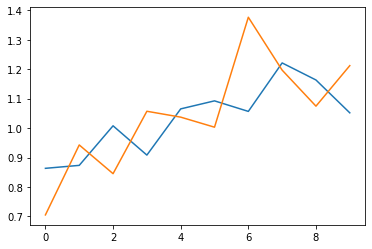

In [57]:
plt.plot(predictions)
plt.plot(y_test_examples)

In [13]:
#Training on individual data points using GradientTape()

#This trains the model in real time in the background.....

#Heavily inspired by keras documentation, "Training loop from scratch"!
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
loss_fn = keras.losses.MeanSquaredError()

x_train = np.array(test_inputs)
y_train = np.array(y_train)

# x_train.shape, y_train.shape
# x_train

array([[[ 6.04050783e-02],
        [ 2.90588445e-01],
        [ 1.05991846e-01],
        [ 2.10385185e-01],
        [ 1.62320972e-01],
        [ 4.16975453e-01],
        [ 1.64633172e-01],
        [ 1.46276086e-01],
        [ 1.45563072e-01],
        [ 3.15071040e-01],
        [ 9.54367200e-02],
        [ 1.97350608e-01],
        [ 6.78301442e-02],
        [ 9.28103546e-02],
        [ 3.52917715e-02],
        [ 2.55365596e-01],
        [ 1.70133304e-01],
        [ 3.34359248e-01],
        [ 9.18892379e-02],
        [ 3.07875384e-01],
        [ 2.08963255e-01],
        [ 1.15804246e-01],
        [ 3.27116535e-01],
        [ 3.40901494e-01],
        [ 1.98173874e-01],
        [ 3.13572957e-01],
        [ 3.00011345e-01],
        [ 1.96092589e-01],
        [ 1.23249123e-01],
        [ 2.88868160e-01],
        [ 2.41257842e-01],
        [ 2.56585110e-01],
        [ 3.41325131e-01],
        [ 2.26512681e-01],
        [ 2.55922659e-01],
        [ 1.12424815e-01],
        [ 2.85756961e-01],
 

In [29]:
@tf.function
def train_loop():
    epochs = 5

    for e in range(epochs):
        for i in range(len(x_train)):
            with tf.GradientTape() as tape:
                logits = model(np.expand_dims(x_train[i], axis=0), training = True)
                loss_value = loss_fn(y_train[i], logits)
            grads = tape.gradient(loss_value, model.trainable_weights)

            optimizer.apply_gradients(zip(grads, model.trainable_weights))

        print('Training loss: ', (e, float(loss_value)))
train_loop()

Training loss:  (0, <tf.Tensor 'mean_squared_error_9/weighted_loss/value:0' shape=() dtype=float32>)



KeyboardInterrupt



In [30]:
test_predictions_ = []
for input_ in test_inputs:
    pred = model.predict(input_)
    test_predictions_.append(pred[0][0])
# plt.plot(test_predictions_)

4/4 [==============================] - 0s 7ms/step


In [31]:
test_inputs = np.array(test_inputs)
test_inputs.shape
predictions_on_array = model.predict(test_inputs)


1/1 [==============================] - 2s 2s/step


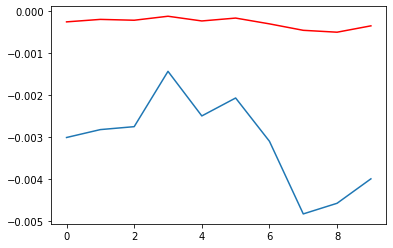

In [38]:
plt.plot(predictions)
plt.plot(predictions_on_array, color='red')

In [119]:
#To train two models concurrently while running the keylogger simultaneously, 

#we likely need to train the model using the GradientTape method.

#Write a training loop from scratch and update all parameters, train the models and if AFK, 

#Run a model.predict function on the future data. #Ofc, because it is trained on a series of Gaussians, 

#we could just generate random Gaussians with random means (itself a Gaussian process!) and simply give them

#extremely wide variances so that we can predict these random clusters for input to the model as a function of 

#time.
car = Vehicle(100, model)

In [107]:
car.listen()

0.0 -1.6927719116210938e-05
0.0 -3.123283386230469e-05
0.0 -4.6253204345703125e-05
0.0 -5.91278076171875e-05
0.0 -7.152557373046875e-05
0.0 -9.369850158691406e-05
0.0 -0.00010991096496582031
0.0 -0.0001239776611328125
0.0 -0.00013875961303710938
0.0 -0.0001537799835205078
0.0 -0.00016832351684570312
0.0 -0.0001544952392578125
0.0 -0.00017642974853515625
-0.00014019012451171875 -0.00017642974853515625
-0.00014019012451171875 -0.0001614093780517578
-0.00014019012451171875 -0.00017762184143066406
-0.00014019012451171875 -0.00015926361083984375
-0.0001533031463623047 -0.00015926361083984375
-0.00013375282287597656 -0.00015926361083984375
-0.00013375282287597656 -0.00014448165893554688
-0.00015401840209960938 -0.00014448165893554688
-0.0001361370086669922 -0.00014448165893554688
-0.00015425682067871094 -0.00014448165893554688
-0.00013685226440429688 -0.00014448165893554688
-0.00015735626220703125 -0.00014448165893554688
-0.00015735626220703125 -0.00012969970703125
-0.00015735626220703125 -0

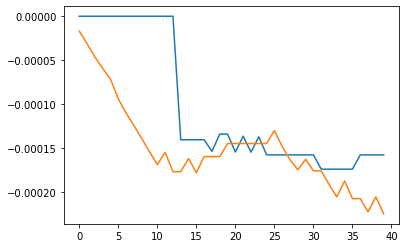

In [108]:
plt.plot(car.vx)
plt.plot(car.vy)

In [109]:
time.sleep(3)
car.autopilot()

1/1 [==============================] - 0s 48ms/step
0.035430707
s
1/1 [==============================] - 0s 47ms/step
0.22351995
s
1/1 [==============================] - 0s 59ms/step
0.65359825
w
1/1 [==============================] - 0s 49ms/step
0.6815619
w
1/1 [==============================] - 0s 49ms/step
0.43994108
w
1/1 [==============================] - 0s 48ms/step
0.23846792
w
1/1 [==============================] - 0s 61ms/step
-0.010942601
w
1/1 [==============================] - 0s 57ms/step
0.025718026
w
1/1 [==============================] - 0s 54ms/step
0.062581375
s
1/1 [==============================] - 0s 50ms/step
0.14434811
w
1/1 [==============================] - 0s 52ms/step
0.12842771
w
1/1 [==============================] - 0s 56ms/step
-0.0065998985
w
1/1 [==============================] - 0s 56ms/step
0.032959376
w
1/1 [==============================] - 0s 61ms/step
-0.043629423
s
1/1 [==============================] - 0s 59ms/step
0.49821427
w
1/1 [==========

In [110]:
#

(-1.6927719116210938e-05, 0.6815619)

40 40


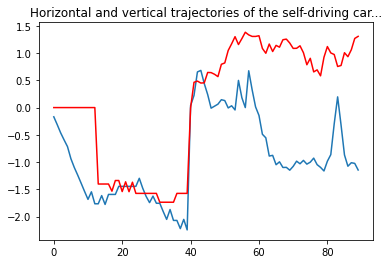

In [113]:
#This car drives itself... possibly for the worst!
#In order to better model self-driving behaviours, it'd need to be trained on driver data!
#Here is the trajectory of the car


#Using numerical integration enabled, i.e. varying timestep sizes
total_vertical_path = (np.array(car.vy) * 10000).tolist() + car.y_predicted
total_horizontal_path = (np.array(car.vx) * 10000).tolist() + car.x_predicted

print(len(car.vx), len(car.vy))

plt.title("Horizontal and vertical trajectories of the self-driving car...")
plt.plot(total_vertical_path)
plt.plot(total_horizontal_path, color='red')
# plt.plot(np.array(y_) * 0.0001, color='red')

In [120]:
#Let alpha = 0.1 
car.numerical_integration_enabled = False
print(car.numerical_integration_enabled)

car.listen()

False
0.0 0.1
0.0 0.2
0.0 0.30000000000000004
0.0 0.4
0.0 0.5
0.0 0.6
0.0 0.7
0.0 0.7999999999999999
0.0 0.8999999999999999
0.0 0.9999999999999999
0.0 0.8999999999999999
0.0 0.7999999999999999
0.0 0.7
0.0 0.7999999999999999
0.0 0.7
0.0 0.7999999999999999
0.1 0.7999999999999999
0.1 0.8999999999999999
0.1 0.7999999999999999
0.1 0.8999999999999999
0.2 0.8999999999999999
0.2 0.9999999999999999
0.2 0.8999999999999999
0.2 0.8999999999999999
0.1 0.8999999999999999
0.0 0.8999999999999999
-0.1 0.8999999999999999
-0.1 0.7999999999999999
-0.1 0.8999999999999999
0.0 0.8999999999999999
0.0 0.9999999999999999
0.0 0.8999999999999999
0.0 0.9999999999999999
-0.1 0.9999999999999999
-0.1 1.0999999999999999
-0.1 0.9999999999999999
-0.1 1.0999999999999999
1.0999999999999999


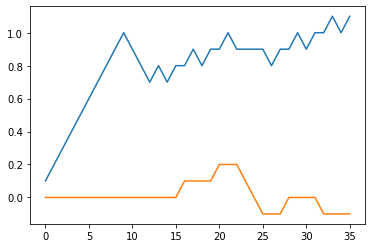

In [121]:
plt.plot(car.vy)
plt.plot(car.vx)

In [122]:
time.sleep(3)
car.autopilot()

1/1 [==============================] - 0s 57ms/step
1.0968686
w
1/1 [==============================] - 0s 63ms/step
1.0102273
w
1/1 [==============================] - 0s 58ms/step
0.9645395
w
1/1 [==============================] - 0s 61ms/step
0.94058836
s
1/1 [==============================] - 0s 52ms/step
1.054372
w
1/1 [==============================] - 0s 50ms/step
1.0277336
s
1/1 [==============================] - 0s 65ms/step
1.2509187
s
1/1 [==============================] - 0s 55ms/step
1.2088332
s
1/1 [==============================] - 0s 61ms/step
1.2164618
s
1/1 [==============================] - 0s 52ms/step
1.2837937
s
1/1 [==============================] - 0s 46ms/step
1.275531
s
1/1 [==============================] - 0s 48ms/step
1.4363793
s
1/1 [==============================] - 0s 58ms/step
1.5024415
s
1/1 [==============================] - 0s 61ms/step
1.4593203
s
1/1 [==============================] - 0s 51ms/step
1.4745377
s
1/1 [==============================] - 0s

40 40


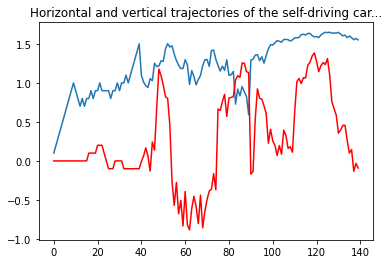

In [128]:
#This car drives itself... possibly for the worst!
#In order to better model self-driving behaviours, it'd need to be trained on driver data!
#Here is the trajectory of the car


#Using numerical integration enabled, i.e. varying timestep sizes
total_vertical_path = (np.array(car.vy)).tolist() + car.y_predicted
total_horizontal_path = (np.array(car.vx)).tolist() + car.x_predicted

#This indicates that an AI takes over at the x=36 mark of both vertical and horizontal processes

print(len(car.vx), len(car.vy))


'''THAT IS AN AWESOME TRAJECTORY!!! :)'''
plt.title("Horizontal and vertical trajectories of the self-driving car...")
plt.plot(total_vertical_path) '''Vertical path appears less chaotic; reason likely being that at any given time,
there is more training data for forwards/backwards motin 
'''
plt.plot(total_horizontal_path, color='red')
# plt.plot(np.array(y_) * 0.0001, color='red')

# CONCLUSIONS: 

### There are a few very useful steps used in order to facilitate 'blind self-driving' via behavioural cloning.
### (1) Load the pretrained Keras model provided
### (2) Initialise object of the class Vehicle with num_data_pts = 100
### (3) Set numerical_integration_enabled to False by writing cars.numerical_integration_enabled = False
### (4) Accumulate data via cars.listen(), and use 'p' to initiate autopilot
###  (5) Use either 'o' or escape key to end the pred loop for the modele

In [126]:
time.sleep(3)
car.autopilot()

1/1 [==============================] - 0s 55ms/step
1.2934246
s
1/1 [==============================] - 0s 54ms/step
1.3011845
s
1/1 [==============================] - 0s 70ms/step
1.3562777
s
1/1 [==============================] - 0s 68ms/step
1.3615946
s
1/1 [==============================] - 0s 62ms/step
1.2856945
s
1/1 [==============================] - 0s 54ms/step
1.3340455
s
1/1 [==============================] - 0s 53ms/step
1.2528099
s
1/1 [==============================] - 0s 56ms/step
1.3501438
s
1/1 [==============================] - 0s 59ms/step
1.4368416
s
1/1 [==============================] - 0s 49ms/step
1.4894173
s
1/1 [==============================] - 0s 58ms/step
1.4858189
s
1/1 [==============================] - 0s 53ms/step
1.5138465
s
1/1 [==============================] - 0s 55ms/step
1.5413046
s
1/1 [==============================] - 0s 49ms/step
1.5331757
s
1/1 [==============================] - 0s 51ms/step
1.5213434
s
1/1 [==============================] - 0

# NEXT STEPS

### Write a Python .py file containing the relevant information for this programme, and redesign the car.autopilot() method to only start the two LSTM prediction threads if 'p' is clicked; otherwise, only activate the car.listen() thread.

### If you do that, you've built a fully functioning self-driving car model for use in GTA 5/6 and Forza!
### It further validates my theory of implementing random sampling as per a martingale sequence as a technique of regularizing a recurrent LSTM network- for different reasons it works for Variational Autoencoders as well as Generative Adversarial Networks, but for mathematical reasons that I have some written proofs for, it should work quite well for recurrent deep learning models.

### Part of the magic here is that the model used to predict self-driving behaviours from keypresses is pretrained on a randomly generated dataset in another notebook. The fact that it still generalizes so well to actual real-world time series data is a testament to how well this approach seems to work.